# Overview of this project
#### Throughout your day, how many different mobile apps do you use? How often would you use your mobile phone if it didn't have any apps? From checking the weather, to searching something on Google, to reading the news and scrolling through social media, most people access a handful of apps before having their breakfast.<br>
Apps are easy to make and can be lucrative for companies that monetize them. This project analyzes and compares over 10,000 apps from the Google App Store, and the insights it provides could be used by companies or entrepreneurial developers to increase profits, drive growth, or improve retention.<br><br>
The data files, *source:* [Kaggle: Google Play Store Apps](https://www.kaggle.com/datasets/lava18/google-play-store-apps?select=googleplaystore_user_reviews.csv), include:
- `apps.csv` : all the details of the apps on Google Play, including Name, Category, Type, Price, Rating, etc.
- `user_reviews.csv` : contains 100 reviews of each app. The text in each review has been pre-processed, passed through a sentiment analyzer engine and tagged with its sentiment score.
</br>

In [115]:
#Read in dataset
from huggingface_hub import hf_hub_download
import pandas as pd

repo_id = "t4tiana/google_play_apps"
csv_filename = "apps.csv"
csv_path = hf_hub_download(
    repo_id,
    csv_filename,
    repo_type="dataset",
)

apps_with_duplicates = pd.read_csv(csv_path, encoding='latin1')

#Drop duplicates
apps = apps_with_duplicates.drop_duplicates()

#The total number of apps
print('Total number of apps in the dataset = ', len(apps))

print('Total apps,columns =', apps.shape)

Total number of apps in the dataset =  10358
Total apps,columns = (10358, 13)


# Cleaning the data
Removing special characters from the **Installs** and **Price** columns to ensure the data is purely numeric.
<br>
Then converting their data types from object to **float**.

In [60]:
chars_to_remove = ['$', ',', '+']
cols_to_clean = ['Installs', 'Price']

#SettingWithCopyWarning raised despite using .loc so this disables it
pd.options.mode.chained_assignment = None

for col in cols_to_clean:
    for char in chars_to_remove:
        # Replace unwanted characters with an empty string
        apps.loc[:,col] = apps.loc[:,col].apply(lambda x: x.replace(char, ''))

In [61]:
#Converting both columns to float
import numpy as np

apps['Installs'] = apps['Installs'].astype(float)
apps['Price'] = apps['Price'].astype(float)

#Confirming Dtypes are float
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10358 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10358 non-null  object 
 1   Category        10357 non-null  object 
 2   Rating          8893 non-null   float64
 3   Reviews         10358 non-null  int64  
 4   Size            10358 non-null  object 
 5   Installs        10358 non-null  float64
 6   Type            10357 non-null  object 
 7   Price           10358 non-null  float64
 8   Content Rating  10358 non-null  object 
 9   Genres          10357 non-null  object 
 10  Last Updated    10358 non-null  object 
 11  Current Ver     10350 non-null  object 
 12  Android Ver     10356 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 1.1+ MB


# Exploring which app categories are the largest

Number of categories =  33


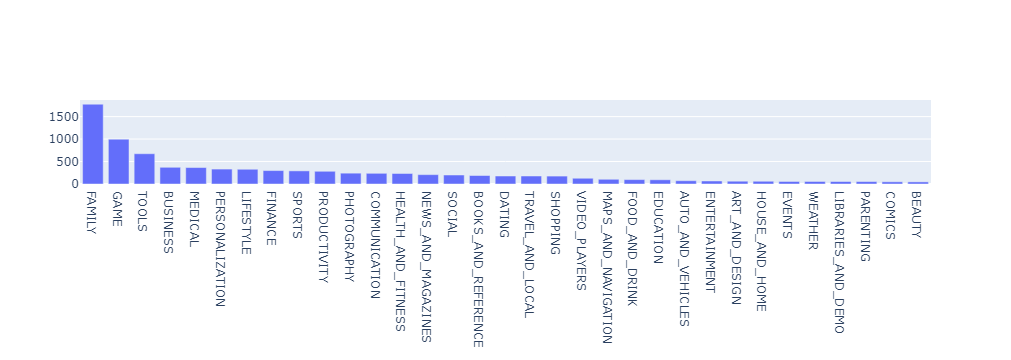

,Category
FAMILY,1776
GAME,997
TOOLS,674
BUSINESS,372
MEDICAL,366


In [81]:
#Creating data for a bar chart that shows the distribution of apps across categories
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

num_categories = set(apps['Category'].dropna())
print('Number of categories = ', len(num_categories))

#Number of apps in each category 
num_apps_in_category = apps['Category'].value_counts()

#Plotly bar graph to visualize
cat_data = [go.Bar(
        x = num_apps_in_category.index, #index = category name
        y = num_apps_in_category.values, #value = count
)]

plotly.offline.iplot(cat_data)

top_5_df = pd.DataFrame(num_apps_in_category)
top_5_df.head()

# Calcuating average app ratings

Average app rating =  4.2
Number of apps with NaN ratings =  1465


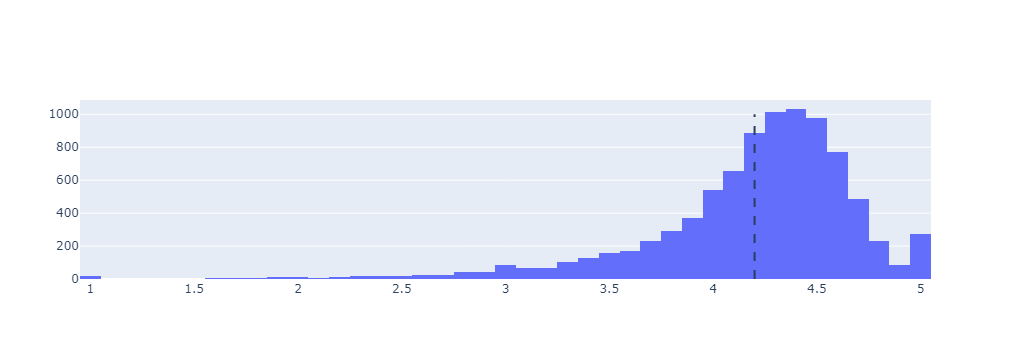

In [63]:
avg_app_rating = apps['Rating'].mean().round(1)
print('Average app rating = ', avg_app_rating)

#Number of NaN values that will be excluded
nan_ratings = apps['Rating'].isna().sum()
print('Number of apps with NaN ratings = ', nan_ratings)

#Plotly distribution of app ratings
rating_data = [go.Histogram(
        x = apps['Rating']
)]

#Vertical dashed line making mean rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dash'}
          }]
          }
plotly.offline.iplot({'data': rating_data, 'layout': layout})

<span style="color:green">One can see that the histogram is skewed to the left, meaning that the majority of apps are rated highly.<br> However, with 1465 out of 10358 apps (14.1%) of apps missing a rating, we cannot be certain that the mean rating is actually 4.2t</span>.

# Visualizing app size and app price
App developers may be interested to know whether or not the size of an app influences how many people will download it. Consumers with older phone models may forgo downloading an app if it takes up too much of their phone's finite storage.<br>
<br>
By also looking at the price of apps on the Google App Store, a developer could answer these questions: <br>

- Does the size of an app affect its rating?
- Do users prefer small-sized apps?
- Does the price of an app affect its rating?
- Do users always prefer free apps over paid apps?
- How can we effectively come up with strategies to size and price our app?

In [77]:
#Dropping apps with missing Rating or Size values
apps_w_size_and_rating = apps.dropna(subset=['Rating', 'Size'])

#Removing apps that have size as "Varies with device"
apps = apps[apps.Size != "Varies with device"]

#Removing apps smaller than 1mb to avoid Size axis being artificially inflated
s = apps.loc[:,'Size']
'''COMMENTING OUT LINE BELOW TO AVOID JUPYTER THROWING ATTRIBUTEERROR
ONCE MADE FLOAT, CANNOT RUN THIS LINE'''
# apps.loc[:,'Size'] = s.str.rstrip('kM')
apps.loc[:,'Size'] = apps.loc[:,'Size'].astype(float)
apps.drop(apps[apps.Size > 100.0].index, inplace=True)

apps['Rating'] = apps['Rating'].astype(float)

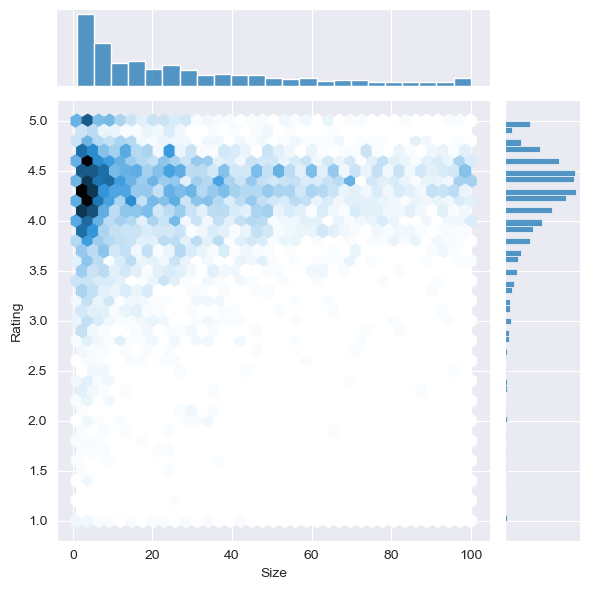

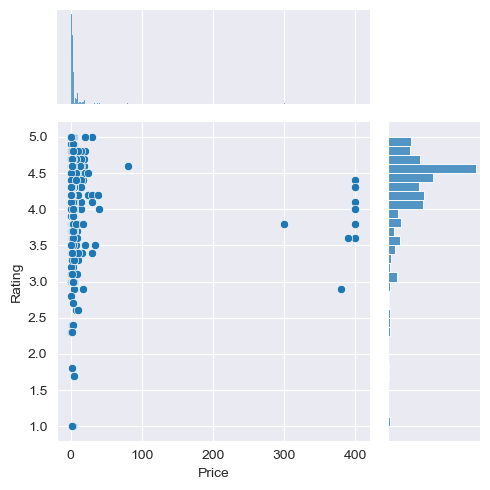

In [79]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
#Ignoring Seaborn warnings
import warnings
warnings.filterwarnings("ignore")

#Subset for categories with at least 250 apps
large_categories = apps_w_size_and_rating.groupby('Category').filter(lambda x: len(x) >= 250)

#Jointplot of Size vs. Rating
plt1 = sns.jointplot(x = large_categories['Size'], y = large_categories['Rating'], kind = 'hex')

#Select only apps where Type == 'Paid'
paid_apps = apps_w_size_and_rating.loc[apps_w_size_and_rating['Type'] == 'Paid']

#Jointplot of Price vs. Rating
plt2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'], height=5, ratio=3)

<span style="color:green">We find that the majority of top-rated apps (rated 4+) are under 20 MB. We also find that the vast majority of apps price themselves under $10.</span>

# Comparing app prices based on category
Companies not only want to cover the cost of developing and maintaining their apps, but also generate profit. Strategies could include offering the app for free but including ads, or having in-app purchases. If an app has a paid download, companies should balance maximum perceived value with going market rates for similar apps, which is possible by looking at data of app prices by Category.

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,I'm rich,399.99
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5355,LIFESTYLE,I am rich VIP,299.99
5356,FINANCE,I Am Rich Premium,399.99
5357,LIFESTYLE,I am extremely Rich,379.99
5358,FINANCE,I am Rich!,399.99
5362,FAMILY,I Am Rich Pro,399.99


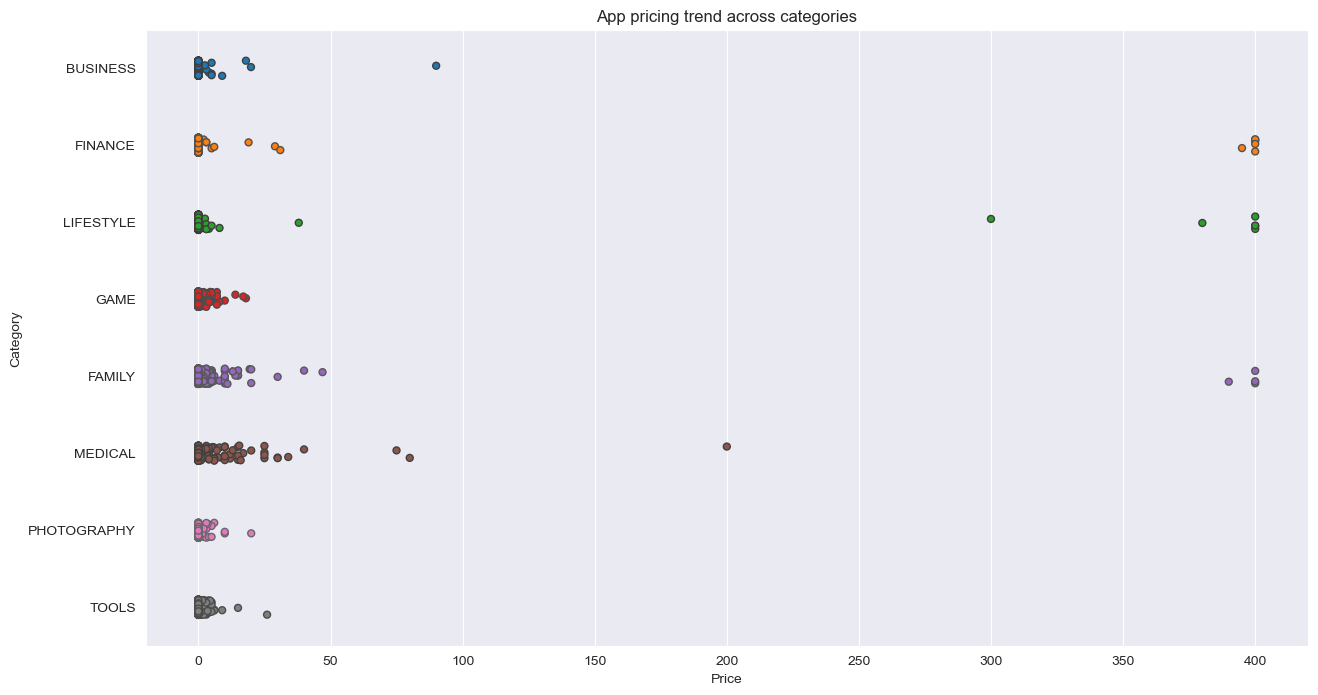

In [87]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

#Selecting some popular app categories to look at
popular_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Examine the price trend by plotting Price vs Category
ax = sns.stripplot(x = popular_cats['Price'], y = popular_cats['Category'], hue= popular_cats['Category'], jitter=True, linewidth=1, legend=False)
ax.set_title('App pricing trend across categories')

# Apps whose Price is greater than 200
apps_above_200 = popular_cats[popular_cats['Price'] > 200]
apps_above_200[['Category', 'App', 'Price']]

<span style = "color:green"> Above, we see that **Medical** and **Family** apps are the most expensive. This could mean that customers perceive the value of these apps to be higher than apps in other categories.<br> All Game apps are priced below $20, which a company should take into consideraion when developing a pricing strategy for their new gaming app.</span>

# Excluding Outliers: Apps priced over $100
Some apps are priced high but don't seem to serve a purpose (*I'm Rich*, *most expensive app*, *I am Rich Plus*, etc.)
Excluding these apps from the strip plot can provide a more useful visualization for someone who wants to understand the pricing of apps in each category.

Text(0.5, 1.0, 'App pricing trend across categories after removing outliers')

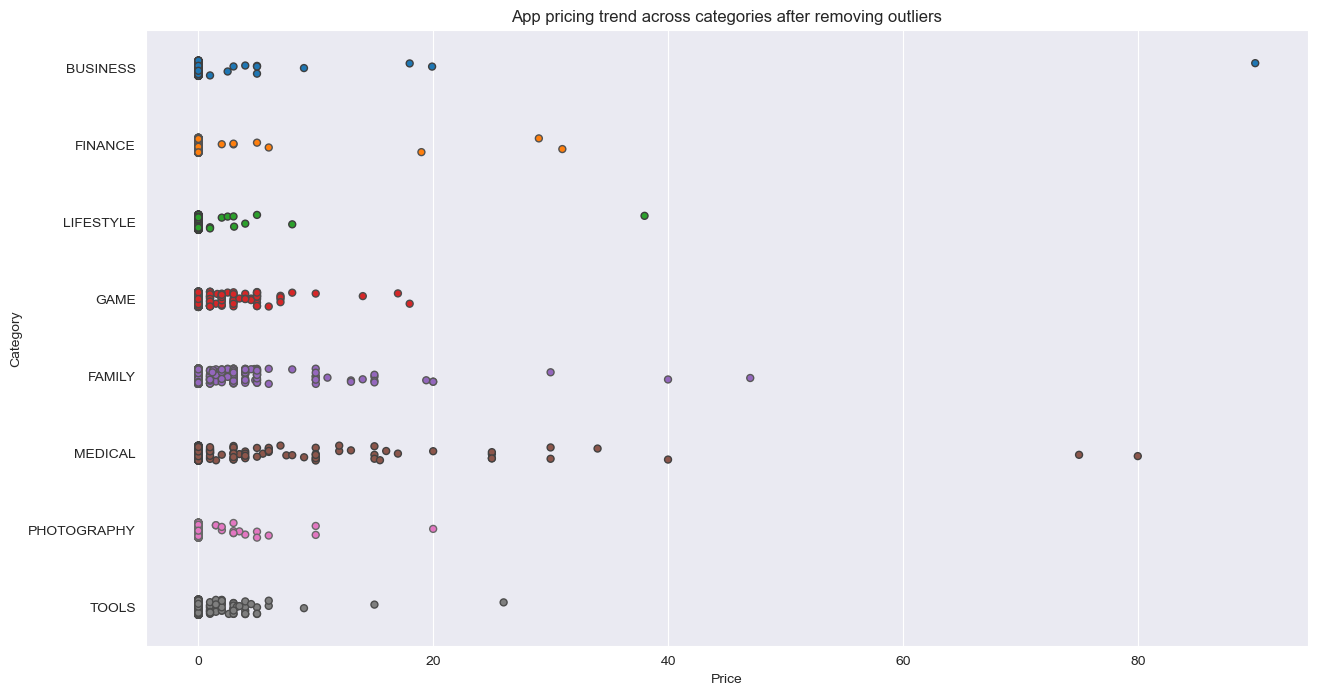

In [95]:
#Apps priced below $100
apps_under_100 = popular_cats[popular_cats['Price']<100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

#Price vs Category for excluding outliers
ax = sns.stripplot(x = apps_under_100['Price'], y = apps_under_100['Category'], hue= apps_under_100['Category'], jitter = True, linewidth = 1, legend=False)
ax.set_title('App pricing trend across categories after removing outliers')

# Number of Installs: Free vs Paid apps

According to Google AdMob there are [5 monetization strategies for apps](https://admob.google.com/home/resources/5-app-monetization-strategies-to-grow-and-monetize-your-app/), 3 of which involve offering a free download.<br>
In the original dataset, 
Apps that are categorized as **Paid**:
- Require the customer to pay in order to download the app
- Don't allow the customer to try the app before they buy it</br>

This is a pretty big commitment. **Does it result in fewer installs?**

<span style="color:green">Of the 10,358 apps that have been analyzed in this dataset, 76.5% are Free to download.<br><br>
One may think that this would result in Paid apps being installed much less frequently, but this box plot shows **this is not the case.**</span>

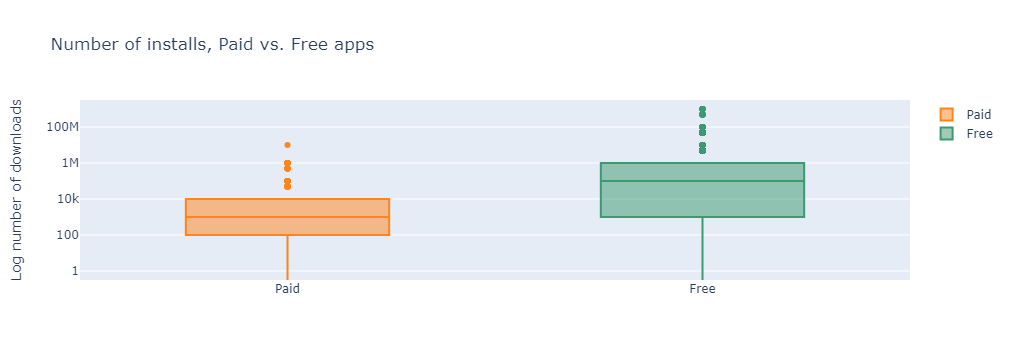

In [102]:
trace0 = go.Box(
    #Data for number of installs of Paid apps
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Paid',
    marker_color= '#FF851B'
)

trace1 = go.Box(
    #Data for number of installs of Free apps
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Free',
    marker_color = "#3D9970"
)

layout = go.Layout(
    title = "Number of installs, Paid vs. Free apps",
    yaxis = dict(title = "Log number of downloads",
                type = 'log',
                autorange = True)
)

#Trace0 and Trace1 in a list for plotting
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

# Sentiment analysis of user review data
About the **user_review** data, quoted from Kaggle:<br>
>*This file contains the first 'most relevant' 100 reviews for each app. Each review text/comment has been pre-processed and attributed with 3 new features - Sentiment, Sentiment Polarity and Sentiment Subjectivity.*
</br>

By plotting sentiment polarity scores of user reviews for paid and free apps, we observe the following:<br>
- Free apps receive more harsh comments, as indicated by the outliers on the negative y-axis.
- Reviews for paid apps appear never to be extremely negative. This may indicate something about app quality, i.e., paid apps being of higher quality than free apps on average.
- The median polarity score for paid apps is a little higher than free apps, in congruence with the previous observation.
</br>
</br>
<span style="color:green">Companies looking to develop apps for download in the Google Play Store could use the analysis in this notebook to inform their decisions around what category of app to create, what size to make it, and how to price it.</span>

Downloading:   0%|          | 0.00/7.60M [00:00<?, ?B/s]

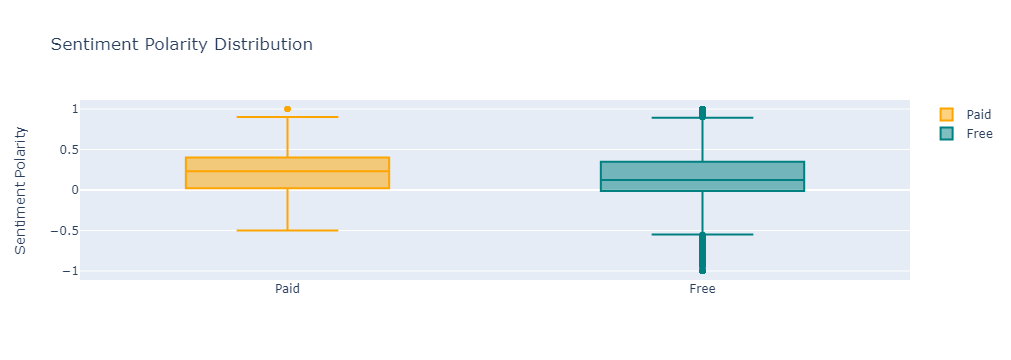

In [116]:
#Getting user_reviews data
repo_id = "t4tiana/google_play_apps"
csv_filename = "user_reviews.csv"
csv_path = hf_hub_download(
    repo_id,
    csv_filename,
    repo_type="dataset",
)

reviews_df = pd.read_csv(csv_path)

#Merging with apps dataframe
merged_df = pd.merge(apps,reviews_df)

#Dropping NA values from Sentiment and Review columns
merged_df = merged_df.dropna(subset = ['Sentiment', 'Rating'])

trace2 = go.Box(
    y = merged_df[merged_df['Type'] == 'Paid']['Sentiment_Polarity'],
    name = 'Paid',
    marker_color= 'orange'
)

trace3 = go.Box(
    y = merged_df[merged_df['Type'] == 'Free']['Sentiment_Polarity'],
    name = 'Free',
    marker_color = "teal"
)

layout = go.Layout(
    title = "Sentiment Polarity Distribution",
    yaxis = dict(title = "Sentiment Polarity",
                autorange = True)
)

#trace2 and trace3 in a list for plotting
data = [trace2, trace3]
plotly.offline.iplot({'data': data, 'layout': layout})